Need to install numpy-stl:
__pip install numpy-stl__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from stl import mesh
from mpl_toolkits import mplot3d
import matplotlib.patches as patches


In [2]:
MESH_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/mesh_files/stl_files/'
print(MESH_DIR)

/home/nci_la/nci_lab/src/pavlov_mini_common/pavlov_mini_description/mesh_files/stl_files/


# Weight list

In [3]:
servo        = 81.4  # g

base_fl      = 35    # g
base_fr      = 35    # g
base_bl      = 35    # g
base_br      = 35    # g

batery       = 259   # g

raspberry_pi = 45    # g
arduino      = 36    # g

bearing      = 11    # g

extra_weight = 50    # g, screws, nuts, cables, etc (stimated)



# 1.-BASE

### Weight

In [4]:
base_mass = servo*4 + base_fl + base_fr + base_bl + base_br + batery + 4*bearing + raspberry_pi + arduino + extra_weight
base_mass = base_mass/1000 # to kg
print('Base mass: {:.3f} Kg'.format(base_mass))

Base mass: 0.900 Kg


### Geometry & Collision

In [5]:
def getVertices(mesh):
    return np.around(np.unique(mesh.vectors.reshape([mesh.vectors.size/3, 3]), axis=0),2)

base_mesh     = mesh.Mesh.from_file(MESH_DIR + 'base.stl')
base_vertices = getVertices(base_mesh)


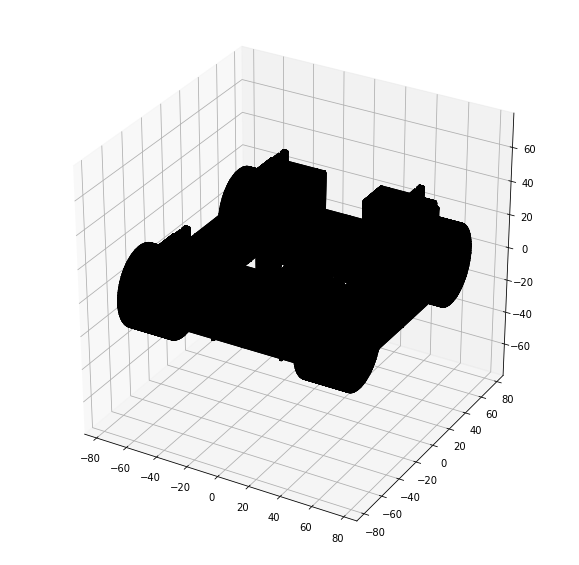

In [6]:
# Create a new plot
figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')


axes.add_collection3d(mplot3d.art3d.Poly3DCollection(base_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)


[[-0.0701   0.0701 ]
 [-0.07686  0.07686]
 [-0.03216  0.0374 ]]


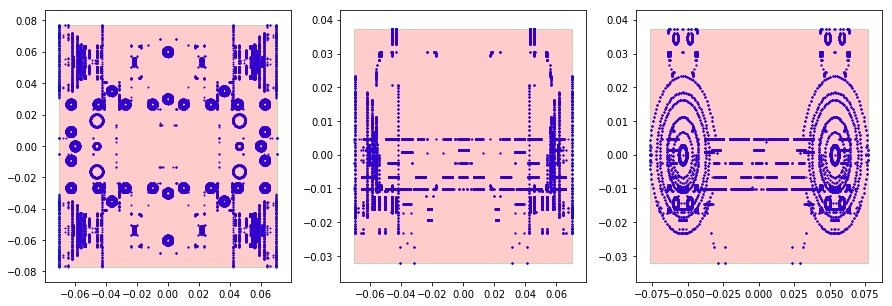

In [7]:
def getMeshLimits(mesh):
    vertices = np.around(np.unique(mesh.vectors.reshape([mesh.vectors.size/3, 3]), axis=0),2)
    vertices = np.true_divide(vertices, 1000)  # Convert to meters
    
    
    x_lim = np.array([np.min(vertices[:,0]), np.max(vertices[:,0])])
    y_lim = np.array([np.min(vertices[:,1]), np.max(vertices[:,1])])
    z_lim = np.array([np.min(vertices[:,2]), np.max(vertices[:,2])])


    fig, axes = plt.subplots(1,3, figsize = (15,5))
    axes[0].scatter(vertices[:,0], vertices[:,1], s = 1, color = 'blue')

    rect_xy = patches.Rectangle((x_lim[0], y_lim[0]),
                                x_lim[1] - x_lim[0],
                                y_lim[1] - y_lim[0],linewidth=1,edgecolor='g',facecolor='red', alpha = 0.2)

    axes[0].add_patch(rect_xy)

    
    
    axes[1].scatter(vertices[:,0], vertices[:,2], s = 1, color = 'blue')
    rect_xz = patches.Rectangle((x_lim[0], z_lim[0]),
                                x_lim[1] - x_lim[0],
                                z_lim[1] - z_lim[0],linewidth=1,edgecolor='g',facecolor='red', alpha = 0.2)
    axes[1].add_patch(rect_xz)

    
    
    axes[2].scatter(vertices[:,1], vertices[:,2], s = 1, color = 'blue')
    rect_yz = patches.Rectangle((y_lim[0], z_lim[0]),
                                y_lim[1] - y_lim[0],
                                z_lim[1] - z_lim[0],linewidth=1,edgecolor='g',facecolor='red', alpha = 0.2)
    axes[2].add_patch(rect_yz)
    
    limits = np.array([x_lim, y_lim, z_lim])
    
    return limits

base_limits = getMeshLimits(base_mesh)
print(base_limits)

### Inertia tensor

Inertia tensor:

\begin{equation}
I = 
\begin{pmatrix}
I_{xx} & I_{xy} & I_{xz} \\
I_{yx} & I_{yy} & I_{yz} \\
I_{zx} & I_{zy} & I_{zz}
\end{pmatrix}
\end{equation}

where: 

\begin{equation}
\begin{cases}
I_{xx} = \int_V (y^2 + z^2)\rho dV \\ 
I_{yy} = \int_V (x^2 + z^2)\rho dV \\ 
I_{zz} = \int_V (x^2 + y^2)\rho dV \\
\end{cases}
\end{equation}

are the mass moments of intertia and

\begin{equation}
\begin{cases}
I_{xy} = I_{yx} =  \int_V (xy)\rho dV \\ 
I_{xz} = I_{zx} = \int_V (xz)\rho dV \\ 
I_{yz} = I_{zy} = \int_V (yz)\rho dV \\
\end{cases}
\end{equation}

### Inertia tensor of rectangular prism
From the center of mass in location $(0,0,0)$ and with dimetions:
\begin{equation}
\begin{cases}
    -\frac{d_x}{2} \leq x < \frac{d_x}{2} \\
    -\frac{d_y}{2} \leq y < \frac{d_y}{2}  \\
    -\frac{d_z}{2} \leq z < \frac{d_z}{2}
\end{cases}
\end{equation}

the intertia tensor is given by
\begin{equation}
I = \frac{m}{12}
\begin{pmatrix}
d_y^2 + d_z^2 & 0               & 0             \\
0               & d_x^2 + d_z^2 & 0             \\
0               & 0             & d_x^2 + d_y^2
\end{pmatrix}
\end{equation}

The transformation to another point of the inertial tensor is given by Steiner's theorem:

\begin{equation}
I'_{ij} = I_{ij} + m\Big(||\mathbf{R}||\delta_{ij} - R_{i}R_j\Big)
\end{equation}

where $\mathbf{R} = (R_x, R_y, R_z)$ is the distance from the center of mass, the position of the new origin.

All meshes files are exported centered in the origin, so that the origin of the mesh is considered at (0,0,0). In that case, we first compute the inertia tensor from the center of mass of the rectangle prism. Then, we transform the inertia tensor to the origin.

The limits of a mesh are given by:

\begin{equation}
\begin{cases}
    x_{min} \leq x < x_{max} \\
    y_{min} \leq y < y_{max} \\
    z_{min} \leq z < z_{max} \\
\end{cases}
\end{equation}

Note that $x_{min}$ is not necessary equal to $x_{max}$. We compute: 

\begin{equation}
\begin{cases}
    d_x = x_{max} - x_{min} \\
    d_y = y_{max} - y_{min} \\
    d_z = z_{max} - z_{min}
\end{cases}
\end{equation}

and calculate the inertia tensor from the center of mass of the rectangle prism. Then, we transform the tensor using the position:

\begin{equation}
\mathbf{R} = -\Big(\frac{ x_{max} + x_{min}}{2}, \frac{ y_{max} + y_{min}}{2}, \frac{ z_{max} + z_{min}}{2} \Big)
\end{equation}

which is the position of the center $(0,0,0)$ from the reference system of the center of mass of the prism

In [8]:
def inertiaFromRectPrism( mass, rect_lims):
    x_lim = rect_lims[0]
    y_lim = rect_lims[1]
    z_lim = rect_lims[2]
    
    dx = x_lim[1] - x_lim[0]
    dy = y_lim[1] - y_lim[0]
    dz = z_lim[1] - z_lim[0]
    
    Ixx_ = (float(mass)/12)*(dy**2 + dz**2)
    Iyy_ = (float(mass)/12)*(dx**2 + dz**2)
    Izz_ = (float(mass)/12)*(dx**2 + dy**2)

    Ixy_ = 0
    Ixz_ = 0
    Iyz_ = 0
    
    ####### Transform with  Steiner's theorem ####
    
    # Note that the origin of the exported stl mesh should be centered at zero. Then we apply
    # the theorem to transform the inertia tensor from the limits to the center (0,0,0)
    
    origin = - np.true_divide(np.sum(rect_lims, axis=1), 2)  # This is the position of the center (0,0,0)
                                                                # respect to the CoM of the rectangle prism
    
    dist = np.linalg.norm(origin)
    
    Ixx = Ixx_ + mass*(dist - origin[0]*origin[0])
    Iyy = Iyy_ + mass*(dist - origin[1]*origin[1])
    Izz = Izz_ + mass*(dist - origin[2]*origin[2])

    Ixy = Ixy_ + mass*( - origin[0]*origin[1])
    Ixz = Ixz_ + mass*( - origin[0]*origin[2])
    Iyz = Iyz_ + mass*( - origin[1]*origin[2])    
    
    
    I = np.array([[ Ixx, Ixy, Ixz ],
                  [ Ixy, Iyy, Iyz ],
                  [ Ixz, Iyz, Izz ]])
    return I



base_origin = np.array([0,0,0])
base_inertia = inertiaFromRectPrism(base_mass ,base_limits)
print(base_inertia)

[[0.00449114 0.         0.        ]
 [0.         0.00419323 0.        ]
 [0.         0.         0.00559578]]


In [9]:
base_link = {}
base_link['name']           = "base_link"
base_link['file']           = "base"
base_link['origin_xyz']     = base_origin
base_link['origin_rpy']     = [0,0,0]
base_link['mass']           = base_mass
base_link['inertia']        = base_inertia
base_link['collision_geom'] = "box"
base_link['collision']      = base_limits


# 2.- HIP

Approximate that the hip has the 2 servos and 2 bearings (1 servo is actually in the the femur). But since all the weight is closer to the body base, this approximation is good for the weight distribution

In [10]:
hip_pla  = 28.5         # g
hip_extra_weight = 20   # g
hip_mass = 2*servo + 2*bearing + hip_pla + hip_extra_weight
hip_mass = float(hip_mass)/1000  # to kg

print('Hip mass: {:.3f} Kg'.format(hip_mass))

Hip mass: 0.233 Kg


In [11]:
hip_fl_mesh     = mesh.Mesh.from_file(MESH_DIR + 'hip_fl.stl')
hip_fl_vertices = getVertices(hip_fl_mesh)

hip_fr_mesh     = mesh.Mesh.from_file(MESH_DIR + 'hip_fr.stl')
hip_fr_vertices = getVertices(hip_fr_mesh)

hip_bl_mesh     = mesh.Mesh.from_file(MESH_DIR + 'hip_bl.stl')
hip_bl_vertices = getVertices(hip_bl_mesh)

hip_br_mesh     = mesh.Mesh.from_file(MESH_DIR + 'hip_br.stl')
hip_br_vertices = getVertices(hip_br_mesh)

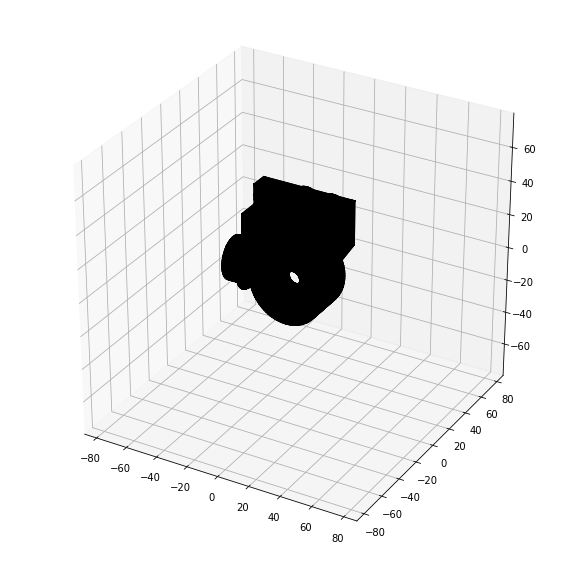

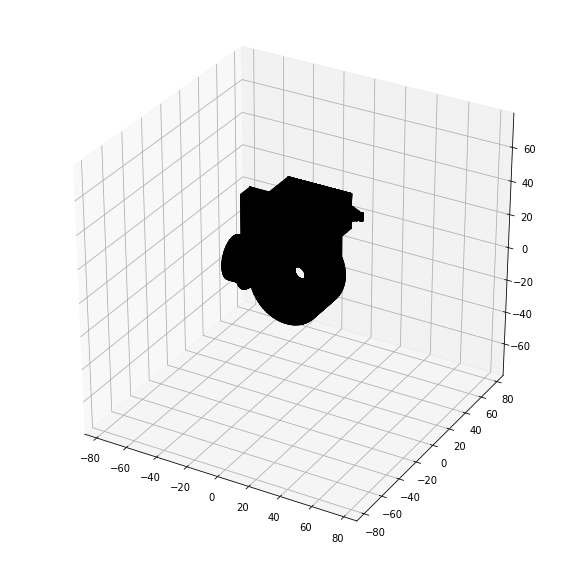

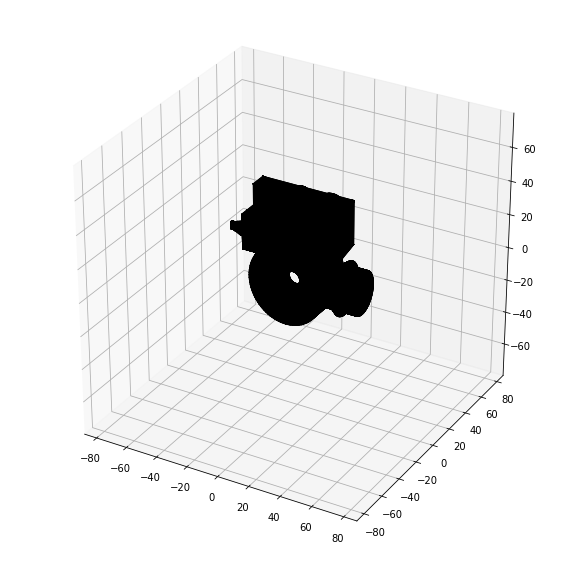

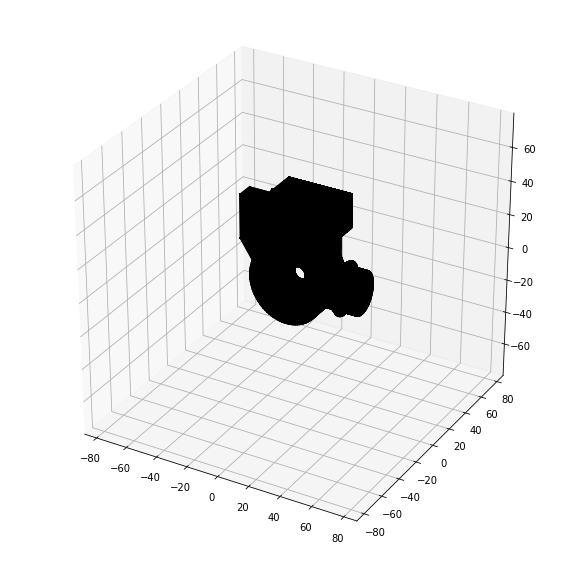

In [12]:
figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(hip_fl_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(hip_fr_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)


figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(hip_bl_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)


figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(hip_br_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)


[[-0.04184  0.02945]
 [-0.02633  0.02561]
 [-0.02358  0.04618]]

[[-0.04184  0.02945]
 [-0.02561  0.02633]
 [-0.02358  0.04618]]

[[-0.02945  0.04184]
 [-0.02633  0.02561]
 [-0.02358  0.04618]]

[[-0.02945  0.04184]
 [-0.02561  0.02633]
 [-0.02358  0.04618]]



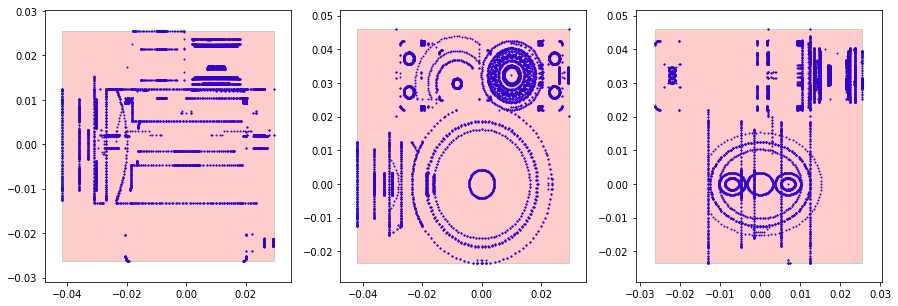

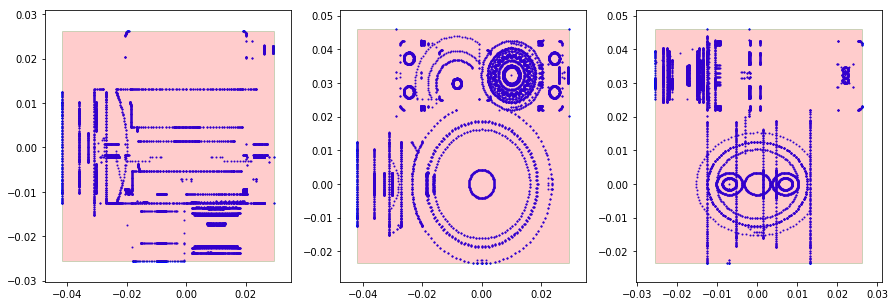

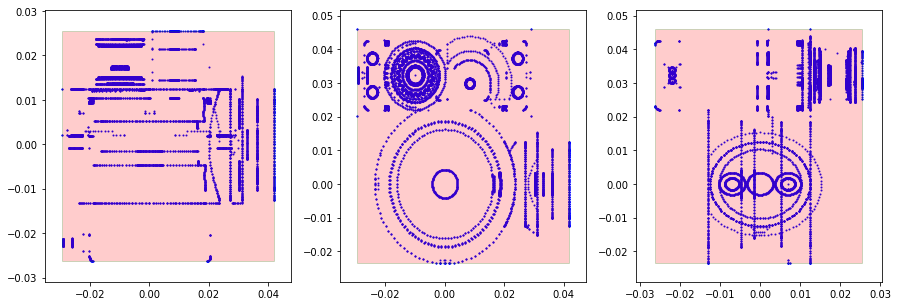

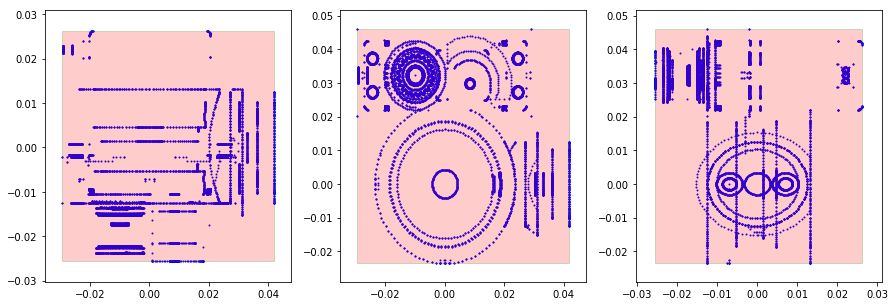

In [13]:
hip_fl_limits = getMeshLimits(hip_fl_mesh)
hip_fr_limits = getMeshLimits(hip_fr_mesh)
hip_bl_limits = getMeshLimits(hip_bl_mesh)
hip_br_limits = getMeshLimits(hip_br_mesh)

print(hip_fl_limits)
print("")
print(hip_fr_limits)
print("")
print(hip_bl_limits)
print("")
print(hip_br_limits)
print("")

In [14]:
hip_origin = np.array([0,0,0])
hip_fl_inertia = inertiaFromRectPrism( hip_mass ,hip_fl_limits)
hip_fr_inertia = inertiaFromRectPrism( hip_mass ,hip_fr_limits)
hip_bl_inertia = inertiaFromRectPrism( hip_mass ,hip_bl_limits)
hip_br_inertia = inertiaFromRectPrism( hip_mass ,hip_br_limits)

tf_base2hip_fl = np.array([ 0.101358, 0.05355,0.000003])
tf_base2hip_fr = np.array([ 0.101358,-0.05355,0.000003])
tf_base2hip_bl = np.array([-0.101358, 0.05355,0.000003])
tf_base2hip_br = np.array([-0.101358,-0.05355,0.000003])


print(hip_fl_inertia)
print("")
print(hip_fr_inertia)
print("")
print(hip_bl_inertia)
print("")
print(hip_br_inertia)
print("")

[[ 3.14575642e-03 -5.20305589e-07  1.63318169e-05]
 [-5.20305589e-07  3.20103845e-03  9.49064230e-07]
 [ 1.63318169e-05  9.49064230e-07  3.12911559e-03]]

[[ 3.14575642e-03  5.20305589e-07  1.63318169e-05]
 [ 5.20305589e-07  3.20103845e-03 -9.49064230e-07]
 [ 1.63318169e-05 -9.49064230e-07  3.12911559e-03]]

[[ 3.14575642e-03  5.20305589e-07 -1.63318169e-05]
 [ 5.20305589e-07  3.20103845e-03  9.49064230e-07]
 [-1.63318169e-05  9.49064230e-07  3.12911559e-03]]

[[ 3.14575642e-03 -5.20305589e-07 -1.63318169e-05]
 [-5.20305589e-07  3.20103845e-03 -9.49064230e-07]
 [-1.63318169e-05 -9.49064230e-07  3.12911559e-03]]



### Ref joints for each legs (where IK is computed from)

In [15]:
from copy import deepcopy

cube_lims = np.true_divide([[-1,1],[-1,1],[-1,1]], 1000)

hip_fl_ref = {}
hip_fl_ref['name']           = "hip_fl_ref"
hip_fl_ref['file']           = "box"
hip_fl_ref['origin_xyz']     = hip_origin
hip_fl_ref['origin_rpy']     = [0,0,0]
hip_fl_ref['mass']           = 0
hip_fl_ref['inertia']        = np.zeros([3,3])
hip_fl_ref['collision_geom'] = "box"
hip_fl_ref['collision']      = cube_lims

hip_fr_ref = deepcopy(hip_fl_ref)
hip_fr_ref['name']           = "hip_fr_ref"

hip_bl_ref = deepcopy(hip_fl_ref)
hip_bl_ref['name']           = "hip_bl_ref"

hip_br_ref = deepcopy(hip_fl_ref)
hip_br_ref['name']           = "hip_br_ref"


joint_fl_ref = {}
joint_fl_ref['name'] = 'fl_ref'
joint_fl_ref['type'] = "fixed"
joint_fl_ref['parent_link'] = 'base_link'
joint_fl_ref['child_link']  = 'hip_fl_ref'
joint_fl_ref['origin_xyz']  = tf_base2hip_fl

joint_fr_ref = {}
joint_fr_ref['name'] = 'fr_ref'
joint_fr_ref['type'] = "fixed"
joint_fr_ref['parent_link'] = 'base_link'
joint_fr_ref['child_link']  = 'hip_fr_ref'
joint_fr_ref['origin_xyz']  = tf_base2hip_fr

joint_bl_ref = {}
joint_bl_ref['name'] = 'bl_ref'
joint_bl_ref['type'] = "fixed"
joint_bl_ref['parent_link'] = 'base_link'
joint_bl_ref['child_link']  = 'hip_bl_ref'
joint_bl_ref['origin_xyz']  = tf_base2hip_bl

joint_br_ref = {}
joint_br_ref['name'] = 'br_ref'
joint_br_ref['type'] = "fixed"
joint_br_ref['parent_link'] = 'base_link'
joint_br_ref['child_link']  = 'hip_br_ref'
joint_br_ref['origin_xyz']  = tf_base2hip_br

### HIP1 joint

In [16]:
hip_fl_link = {}
hip_fl_link['name']          = "hip_fl_link"
hip_fl_link['file']          = "hip_fl"
hip_fl_link['origin_xyz']    = hip_origin
hip_fl_link['origin_rpy']    = [0,0,0]
hip_fl_link['mass']          = hip_mass
hip_fl_link['inertia']       = hip_fl_inertia
hip_fl_link['collision_geom']= "box"
hip_fl_link['collision']     = hip_fl_limits

hip_fr_link = {}
hip_fr_link['name']          = "hip_fr_link"
hip_fr_link['file']          = "hip_fr"
hip_fr_link['origin_xyz']    = hip_origin
hip_fr_link['origin_rpy']    = [0,0,0]
hip_fr_link['mass']          = hip_mass
hip_fr_link['inertia']       = hip_fr_inertia
hip_fr_link['collision_geom']= "box"
hip_fr_link['collision']     = hip_fr_limits

hip_bl_link = {}
hip_bl_link['name']          = "hip_bl_link"
hip_bl_link['file']          = "hip_bl"
hip_bl_link['origin_xyz']    = hip_origin
hip_bl_link['origin_rpy']    = [0,0,0]
hip_bl_link['mass']          = hip_mass
hip_bl_link['inertia']       = hip_bl_inertia
hip_bl_link['collision_geom']= "box"
hip_bl_link['collision']     = hip_bl_limits

hip_br_link = {}
hip_br_link['name']          = "hip_br_link"
hip_br_link['file']          = "hip_br"
hip_br_link['origin_xyz']    = hip_origin
hip_br_link['origin_rpy']    = [0,0,0]
hip_br_link['mass']          = hip_mass
hip_br_link['inertia']       = hip_br_inertia
hip_br_link['collision_geom']= "box"
hip_br_link['collision']     = hip_br_limits

In [17]:
joint_hip1_fl = {}
joint_hip1_fl['name'] = 'hip1_fl'
joint_hip1_fl['type'] = "revolute"
joint_hip1_fl['axis'] = np.array([1,0,0])
joint_hip1_fl['effort'] = 10000
joint_hip1_fl['limits'] = np.array([-90, 90])  # Degrees
joint_hip1_fl['velocity'] = 60                 # Degrees/s
joint_hip1_fl['parent_link'] = 'hip_fl_ref'
joint_hip1_fl['child_link']  = 'hip_fl_link'
joint_hip1_fl['origin_xyz']  = np.zeros(3)

joint_hip1_fr = {}
joint_hip1_fr['name'] = 'hip1_fr'
joint_hip1_fr['type'] = "revolute"
joint_hip1_fr['axis'] = np.array([1,0,0])
joint_hip1_fr['effort'] = 10000
joint_hip1_fr['limits'] = np.array([-90, 90])  # Degrees
joint_hip1_fr['velocity'] = 60                 # Degrees/s
joint_hip1_fr['parent_link'] = 'hip_fr_ref'
joint_hip1_fr['child_link']  = 'hip_fr_link'
joint_hip1_fr['origin_xyz']  = np.zeros(3)

joint_hip1_bl = {}
joint_hip1_bl['name'] = 'hip1_bl'
joint_hip1_bl['type'] = "revolute"
joint_hip1_bl['axis'] = np.array([1,0,0])
joint_hip1_bl['effort'] = 10000
joint_hip1_bl['limits'] = np.array([-90, 90])  # Degrees
joint_hip1_bl['velocity'] = 60                 # Degrees/s
joint_hip1_bl['parent_link'] = 'hip_bl_ref'
joint_hip1_bl['child_link']  = 'hip_bl_link'
joint_hip1_bl['origin_xyz']  = np.zeros(3)


joint_hip1_br = {}
joint_hip1_br['name'] = 'hip1_br'
joint_hip1_br['type'] = "revolute"
joint_hip1_br['axis'] = np.array([1,0,0])
joint_hip1_br['effort'] = 10000
joint_hip1_br['limits'] = np.array([-90, 90])  # Degrees
joint_hip1_br['velocity'] = 60                 # Degrees/s
joint_hip1_br['parent_link'] = 'hip_br_ref'
joint_hip1_br['child_link']  = 'hip_br_link'
joint_hip1_br['origin_xyz']  = np.zeros(3)



# 3.- FEMUR

In [18]:
femur_pla          = 42   # g
femur_extra_weight = 20   # g
femur_mass = 0*servo + 2*bearing + femur_pla + femur_extra_weight
femur_mass = float(femur_mass)/1000  # to kg

print('Femur mass: {:.3f} Kg'.format(femur_mass))

Femur mass: 0.084 Kg


In [19]:
femur_l_mesh     = mesh.Mesh.from_file(MESH_DIR + 'femur_l.stl')
femur_l_vertices = getVertices(femur_l_mesh)

femur_r_mesh     = mesh.Mesh.from_file(MESH_DIR + 'femur_r.stl')
femur_r_vertices = getVertices(femur_r_mesh)

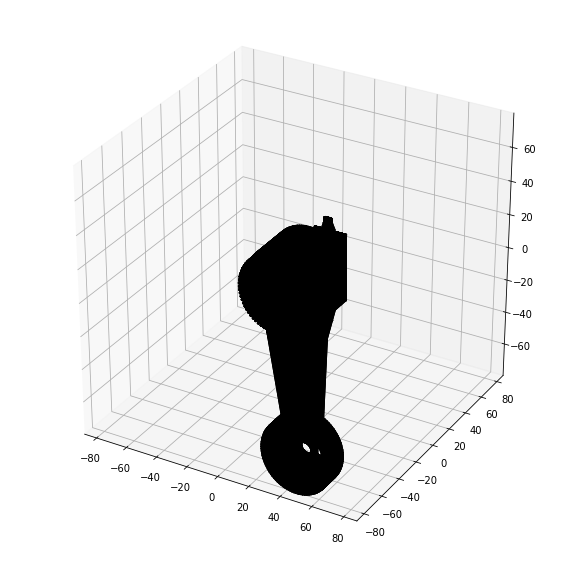

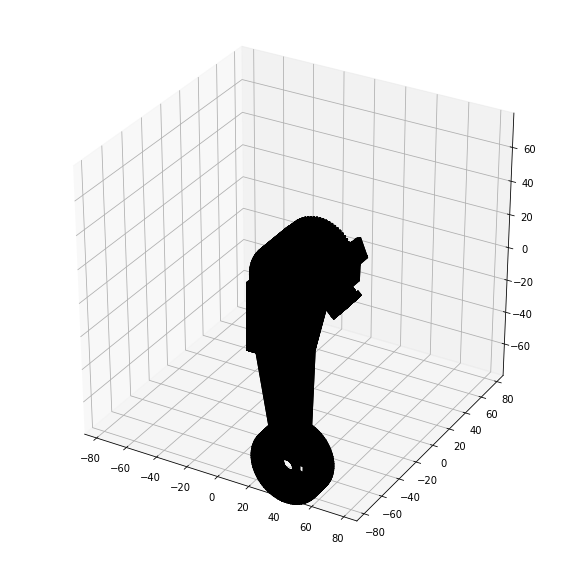

In [20]:
figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(femur_l_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(femur_r_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)



[[-0.02367     0.03093   ]
 [-0.03565     0.03899   ]
 [-0.13703999  0.02383   ]]

[[-0.02367     0.03093   ]
 [-0.039       0.03565   ]
 [-0.13703999  0.02383   ]]



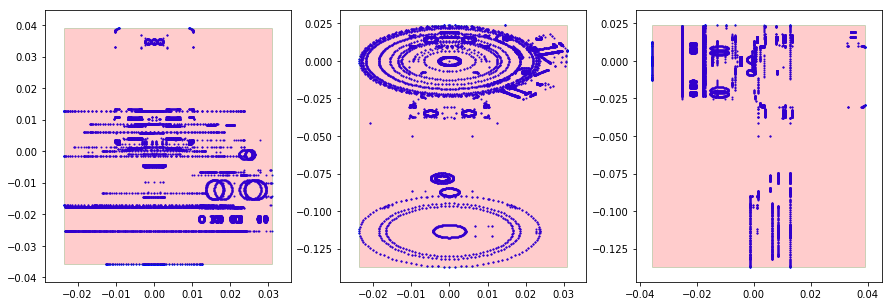

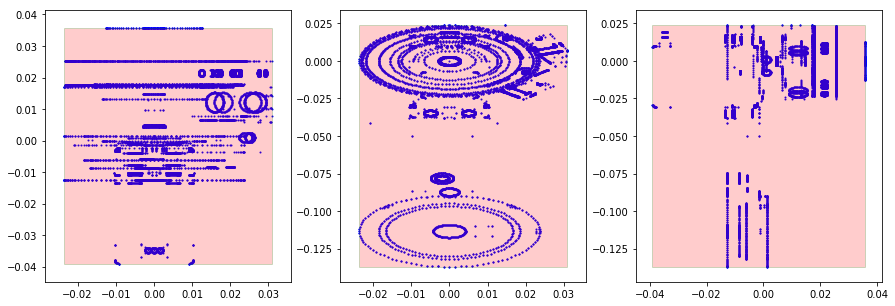

In [21]:
femur_l_limits = getMeshLimits(femur_l_mesh)
femur_r_limits = getMeshLimits(femur_r_mesh)

print(femur_l_limits)
print("")
print(femur_r_limits)
print("")

In [22]:
femur_origin = np.array([0,0,0])
femur_l_inertia = inertiaFromRectPrism( femur_mass , femur_l_limits)
femur_r_inertia = inertiaFromRectPrism( femur_mass , femur_r_limits)

tf_hip_fl2femur_l = np.array([ 0,  0.042, 0])
tf_hip_fr2femur_r = np.array([ 0, -0.042, 0])
tf_hip_bl2femur_l = np.array([ 0,  0.042, 0])
tf_hip_br2femur_r = np.array([ 0, -0.042, 0])


print(femur_l_inertia)
print("")
print(femur_r_inertia)
print("")

[[ 4.98569653e-03 -5.09216634e-07  1.72599923e-05]
 [-5.09216634e-07  4.96843917e-03  7.94055406e-06]
 [ 1.72599923e-05  7.94055406e-06  4.55737082e-03]]

[[ 4.98571918e-03  5.10741032e-07  1.72599923e-05]
 [ 5.10741032e-07  4.96845012e-03 -7.96432470e-06]
 [ 1.72599923e-05 -7.96432470e-06  4.55739347e-03]]



In [23]:
femur_fl_link = {}
femur_fl_link['name']          = "femur_fl_link"
femur_fl_link['file']          = "femur_l"
femur_fl_link['origin_xyz']    = femur_origin
femur_fl_link['origin_rpy']    = [0,0,0]
femur_fl_link['mass']          = femur_mass
femur_fl_link['inertia']       = femur_l_inertia
femur_fl_link['collision_geom']= "box"
femur_fl_link['collision']     = femur_l_limits

femur_fr_link = {}
femur_fr_link['name']          = "femur_fr_link"
femur_fr_link['file']          = "femur_r"
femur_fr_link['origin_xyz']    = femur_origin
femur_fr_link['origin_rpy']    = [0,0,0]
femur_fr_link['mass']          = femur_mass
femur_fr_link['inertia']       = femur_r_inertia
femur_fr_link['collision_geom']= "box"
femur_fr_link['collision']     = femur_r_limits

femur_bl_link = {}
femur_bl_link['name']          = "femur_bl_link"
femur_bl_link['file']          = "femur_l"
femur_bl_link['origin_xyz']    = femur_origin
femur_bl_link['origin_rpy']    = [0,0,0]
femur_bl_link['mass']          = femur_mass
femur_bl_link['inertia']       = femur_l_inertia
femur_bl_link['collision_geom']= "box"
femur_bl_link['collision']     = femur_l_limits

femur_br_link = {}
femur_br_link['name']          = "femur_br_link"
femur_br_link['file']          = "femur_r"
femur_br_link['origin_xyz']    = femur_origin
femur_br_link['origin_rpy']    = [0,0,0]
femur_br_link['mass']          = femur_mass
femur_br_link['inertia']       = femur_r_inertia
femur_br_link['collision_geom']= "box"
femur_br_link['collision']     = femur_r_limits

In [24]:
joint_hip2_fl = {}
joint_hip2_fl['name'] = 'hip2_fl'
joint_hip2_fl['type'] = "revolute"
joint_hip2_fl['axis'] = np.array([0,1,0])
joint_hip2_fl['effort'] = 10000
joint_hip2_fl['limits'] = np.array([0, 180])  # Degrees
joint_hip2_fl['velocity'] = 60                 # Degrees/s
joint_hip2_fl['parent_link'] = 'hip_fl_link'
joint_hip2_fl['child_link']  = 'femur_fl_link'
joint_hip2_fl['origin_xyz']  = tf_hip_fl2femur_l

joint_hip2_fr = {}
joint_hip2_fr['name'] = 'hip2_fr'
joint_hip2_fr['type'] = "revolute"
joint_hip2_fr['axis'] = np.array([0,1,0])
joint_hip2_fr['effort'] = 10000
joint_hip2_fr['limits'] = np.array([0, 180])  # Degrees
joint_hip2_fr['velocity'] = 60                 # Degrees/s
joint_hip2_fr['parent_link'] = 'hip_fr_link'
joint_hip2_fr['child_link']  = 'femur_fr_link'
joint_hip2_fr['origin_xyz']  = tf_hip_fr2femur_r

joint_hip2_bl = {}
joint_hip2_bl['name'] = 'hip2_bl'
joint_hip2_bl['type'] = "revolute"
joint_hip2_bl['axis'] = np.array([0,1,0])
joint_hip2_bl['effort'] = 10000
joint_hip2_bl['limits'] = np.array([0, 180])  # Degrees
joint_hip2_bl['velocity'] = 60                 # Degrees/s
joint_hip2_bl['parent_link'] = 'hip_bl_link'
joint_hip2_bl['child_link']  = 'femur_bl_link'
joint_hip2_bl['origin_xyz']  = tf_hip_bl2femur_l

joint_hip2_br = {}
joint_hip2_br['name'] = 'hip2_br'
joint_hip2_br['type'] = "revolute"
joint_hip2_br['axis'] = np.array([0,1,0])
joint_hip2_br['effort'] = 10000
joint_hip2_br['limits'] = np.array([0, 180])  # Degrees
joint_hip2_br['velocity'] = 60                 # Degrees/s
joint_hip2_br['parent_link'] = 'hip_br_link'
joint_hip2_br['child_link']  = 'femur_br_link'
joint_hip2_br['origin_xyz']  = tf_hip_br2femur_r


# Tibia

In [25]:
tibia_pla          = 34   # g
tibia_extra_weight = 0   # g
tibia_mass = 0*bearing + tibia_pla + tibia_extra_weight
tibia_mass = float(tibia_mass)/1000  # to kg

print('Tibia mass: {:.3f} Kg'.format(tibia_mass))

Tibia mass: 0.034 Kg


In [26]:
tibia_l_mesh     = mesh.Mesh.from_file(MESH_DIR + 'tibia_l.stl')
tibia_l_vertices = getVertices(tibia_l_mesh)

tibia_r_mesh     = mesh.Mesh.from_file(MESH_DIR + 'tibia_r.stl')
tibia_r_vertices = getVertices(tibia_r_mesh)

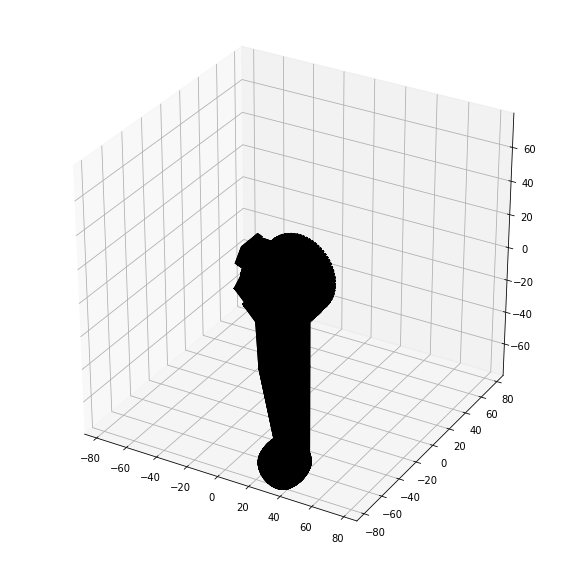

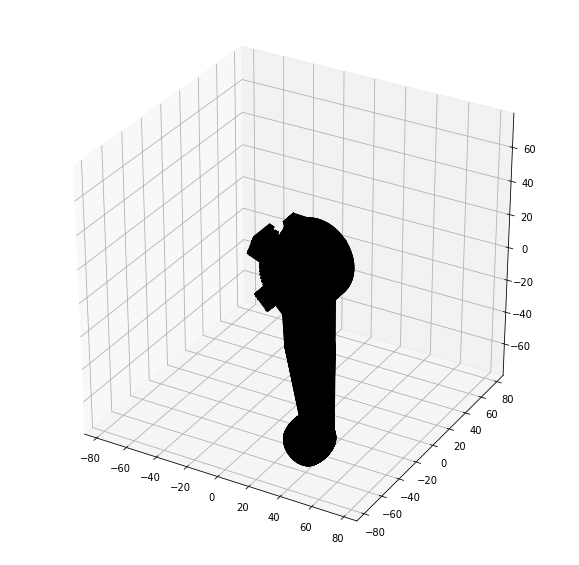

In [27]:
figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(tibia_l_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

figure = plt.figure(figsize = (10,10))
axes = figure.gca(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(tibia_r_mesh.vectors, color='black'))
scale = base_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)


[[-0.03118  0.02367]
 [-0.02279  0.01205]
 [-0.12354  0.02367]]

[[-0.03118  0.02367]
 [-0.01205  0.02279]
 [-0.12354  0.02367]]



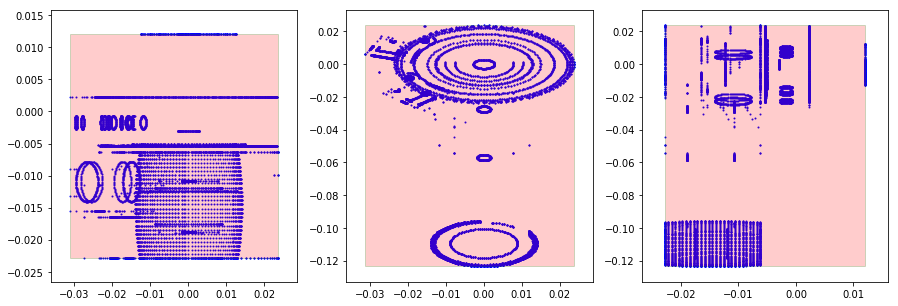

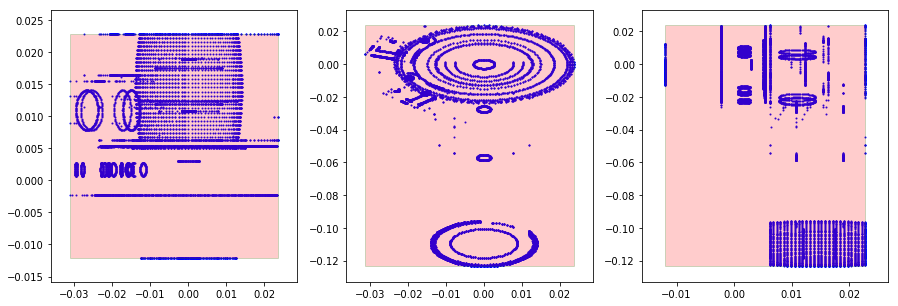

In [28]:
tibia_l_limits = getMeshLimits(tibia_l_mesh)
tibia_r_limits = getMeshLimits(tibia_r_mesh)

print(tibia_l_limits)
print("")
print(tibia_r_limits)
print("")

In [29]:
tibia_origin = np.array([0,0,0])
tibia_l_inertia = inertiaFromRectPrism( tibia_mass , tibia_l_limits)
tibia_r_inertia = inertiaFromRectPrism( tibia_mass , tibia_r_limits)

tf_femur_fl2tibia_fl = np.array([0, -0.004365, -0.113353])
tf_femur_fr2tibia_fr = np.array([0,  0.004365, -0.113353])
tf_femur_bl2tibia_bl = np.array([0, -0.004365, -0.113353])
tf_femur_br2tibia_br = np.array([0,  0.004365, -0.113353])


print(tibia_l_inertia)
print("")
print(tibia_r_inertia)
print("")

[[ 1.77670538e-03 -6.85587922e-07 -6.37520044e-06]
 [-6.85587922e-07  1.78128929e-03 -9.11713380e-06]
 [-6.37520044e-06 -9.11713380e-06  1.63952923e-03]]

[[ 1.77670538e-03  6.85587922e-07 -6.37520044e-06]
 [ 6.85587922e-07  1.78128929e-03  9.11713380e-06]
 [-6.37520044e-06  9.11713380e-06  1.63952923e-03]]



In [30]:
tibia_fl_link = {}
tibia_fl_link['name']          = "tibia_fl_link"
tibia_fl_link['file']          = "tibia_l"
tibia_fl_link['origin_xyz']    = tibia_origin
tibia_fl_link['origin_rpy']    = [0,0,0]
tibia_fl_link['mass']          = tibia_mass
tibia_fl_link['inertia']       = tibia_l_inertia
tibia_fl_link['collision_geom']= "file"
tibia_fl_link['collision']     = tibia_l_limits

tibia_fr_link = {}
tibia_fr_link['name']          = "tibia_fr_link"
tibia_fr_link['file']          = "tibia_r"
tibia_fr_link['origin_xyz']    = tibia_origin
tibia_fr_link['origin_rpy']    = [0,0,0]
tibia_fr_link['mass']          = tibia_mass
tibia_fr_link['inertia']       = tibia_r_inertia
tibia_fr_link['collision_geom']= "file"
tibia_fr_link['collision']     = tibia_r_limits

tibia_bl_link = {}
tibia_bl_link['name']          = "tibia_bl_link"
tibia_bl_link['file']          = "tibia_l"
tibia_bl_link['origin_xyz']    = tibia_origin
tibia_bl_link['origin_rpy']    = [0,0,0]
tibia_bl_link['mass']          = tibia_mass
tibia_bl_link['inertia']       = tibia_l_inertia
tibia_bl_link['collision_geom']= "file"
tibia_bl_link['collision']     = tibia_l_limits

tibia_br_link = {}
tibia_br_link['name']          = "tibia_br_link"
tibia_br_link['file']          = "tibia_r"
tibia_br_link['origin_xyz']    = tibia_origin
tibia_br_link['origin_rpy']    = [0,0,0]
tibia_br_link['mass']          = tibia_mass
tibia_br_link['inertia']       = tibia_r_inertia
tibia_br_link['collision_geom']= "file"
tibia_br_link['collision']     = tibia_r_limits

In [31]:
joint_knee_fl = {}
joint_knee_fl['name'] = 'knee_fl'
joint_knee_fl['type'] = "revolute"
joint_knee_fl['axis'] = np.array([0,1,0])
joint_knee_fl['effort'] = 10000
joint_knee_fl['limits'] = np.array([-180, 0])  # Degrees
joint_knee_fl['velocity'] = 60                 # Degrees/s
joint_knee_fl['parent_link'] = 'femur_fl_link'
joint_knee_fl['child_link']  = 'tibia_fl_link'
joint_knee_fl['origin_xyz']  = tf_femur_fl2tibia_fl

joint_knee_fr = {}
joint_knee_fr['name'] = 'knee_fr'
joint_knee_fr['type'] = "revolute"
joint_knee_fr['axis'] = np.array([0,1,0])
joint_knee_fr['effort'] = 10000
joint_knee_fr['limits'] = np.array([-180, 0])  # Degrees
joint_knee_fr['velocity'] = 60                 # Degrees/s
joint_knee_fr['parent_link'] = 'femur_fr_link'
joint_knee_fr['child_link']  = 'tibia_fr_link'
joint_knee_fr['origin_xyz']  = tf_femur_fr2tibia_fr

joint_knee_bl = {}
joint_knee_bl['name'] = 'knee_bl'
joint_knee_bl['type'] = "revolute"
joint_knee_bl['axis'] = np.array([0,1,0])
joint_knee_bl['effort'] = 10000
joint_knee_bl['limits'] = np.array([-180, 0])  # Degrees
joint_knee_bl['velocity'] = 60                 # Degrees/s
joint_knee_bl['parent_link'] = 'femur_bl_link'
joint_knee_bl['child_link']  = 'tibia_bl_link'
joint_knee_bl['origin_xyz']  = tf_femur_bl2tibia_bl

joint_knee_br = {}
joint_knee_br['name'] = 'knee_br'
joint_knee_br['type'] = "revolute"
joint_knee_br['axis'] = np.array([0,1,0])
joint_knee_br['effort'] = 10000
joint_knee_br['limits'] = np.array([-180, 0])  # Degrees
joint_knee_br['velocity'] = 60                 # Degrees/s
joint_knee_br['parent_link'] = 'femur_br_link'
joint_knee_br['child_link']  = 'tibia_br_link'
joint_knee_br['origin_xyz']  = tf_femur_br2tibia_br

# 4 Feet

In [32]:
tf_tibia_fl2feet_fl = [0, -0.014513, -0.10938]
tf_tibia_fr2feet_fr = [0,  0.014513, -0.10938]
tf_tibia_bl2feet_bl = [0, -0.014513, -0.10938]
tf_tibia_br2feet_br = [0,  0.014513, -0.10938]

In [33]:
cube_lims = np.true_divide([[-1,1],[-1,1],[-1,1]], 1000)
feet_origin = np.zeros(3)


feet_fl_link = {}
feet_fl_link['name']          = "feet_fl"
feet_fl_link['file']          = "box"
feet_fl_link['origin_xyz']    = feet_origin
feet_fl_link['origin_rpy']    = [0,0,0]
feet_fl_link['mass']          = 0
feet_fl_link['inertia']       = np.zeros([3,3])
feet_fl_link['collision_geom']= "box"
feet_fl_link['collision']     = cube_lims

feet_fr_link = deepcopy(feet_fl_link)
feet_fr_link['name']          = "feet_fr"

feet_bl_link = deepcopy(feet_fl_link)
feet_bl_link['name']          = "feet_bl"

feet_br_link = deepcopy(feet_fl_link)
feet_br_link['name']          = "feet_br"


joint_feet_fl_ref = {}
joint_feet_fl_ref['name']        = 'feet_fl_ref'
joint_feet_fl_ref['type']        = "fixed"
joint_feet_fl_ref['parent_link'] = 'tibia_fl_link'
joint_feet_fl_ref['child_link']  = 'feet_fl'
joint_feet_fl_ref['origin_xyz']  = tf_tibia_fl2feet_fl

joint_feet_fr_ref = {}
joint_feet_fr_ref['name']        = 'feet_fr_ref'
joint_feet_fr_ref['type']        = "fixed"
joint_feet_fr_ref['parent_link'] = 'tibia_fr_link'
joint_feet_fr_ref['child_link']  = 'feet_fr'
joint_feet_fr_ref['origin_xyz']  = tf_tibia_fr2feet_fr

joint_feet_bl_ref = {}
joint_feet_bl_ref['name']        = 'feet_bl_ref'
joint_feet_bl_ref['type']        = "fixed"
joint_feet_bl_ref['parent_link'] = 'tibia_bl_link'
joint_feet_bl_ref['child_link']  = 'feet_bl'
joint_feet_bl_ref['origin_xyz']  = tf_tibia_bl2feet_bl

joint_feet_br_ref = {}
joint_feet_br_ref['name']        = 'feet_br_ref'
joint_feet_br_ref['type']        = "fixed"
joint_feet_br_ref['parent_link'] = 'tibia_br_link'
joint_feet_br_ref['child_link']  = 'feet_br'
joint_feet_br_ref['origin_xyz']  = tf_tibia_br2feet_br

# Write URDF robot model

In [36]:
def writeLine(f, line):
    f.write(line + '\n')
    

def writeURDFfile(links, joints, name = 'pavlov_mini', package = "pavlov_mini_description", mesh_format = 'dae', collisionFile = False):
    URDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/urdf/'
    MESH_DIR = "package://" + package + '/mesh_files/{:s}_files/'.format(mesh_format)

    f = open(URDF_DIR + name + '.urdf', 'w')
    
    writeLine(f, '<?xml version="1.0"?>')
    writeLine(f, '<robot name="' + name + '">')
    
    for link in links:
        
                
        x_lim = link['collision'][0]
        y_lim = link['collision'][1]
        z_lim = link['collision'][2]
        
        origin_x = (x_lim[1] + x_lim[0])/2
        origin_y = (y_lim[1] + y_lim[0])/2
        origin_z = (z_lim[1] + z_lim[0])/2
        
        dx = (x_lim[1] - x_lim[0])
        dy = (y_lim[1] - y_lim[0])
        dz = (z_lim[1] - z_lim[0])

        
        writeLine(f, '  <link name="{:s}">'.format(link['name']))
        writeLine(f, '    <visual>')
        
        if collisionFile and link['collision_geom'] == 'box':
            writeLine(f, '    <origin xyz="{:.3f} {:.3f} {:.3f}" rpy ="{:.3f} {:.3f} {:.3f}"/>'.format(origin_x, 
                                                                                                       origin_y, 
                                                                                                       origin_z,
                                                                                                       0, 
                                                                                                       0, 
                                                                                                       0))
            
            
        writeLine(f, '      <geometry>')
        if not collisionFile:
            if link['file'] != "box":
                writeLine(f, '        <mesh filename= "{:s}{:s}.{:s}"/>'.format(MESH_DIR, link['file'], mesh_format))
            else:
                writeLine(f, '        <box size="{:.3f} {:.3f} {:.3f}"/>'.format(dx, dy, dz))

        else:
            
            if link['collision_geom'] == 'box':
                writeLine(f, '        <box size="{:.3f} {:.3f} {:.3f}"/>'.format(dx, dy, dz))
            else:
                writeLine(f, '        <mesh filename= "{:s}{:s}.{:s}"/>'.format(MESH_DIR, link['file'], mesh_format))

        
        writeLine(f, '      </geometry>')
        writeLine(f, '    </visual>')

        writeLine(f, '    <inertial>')
        writeLine(f, '      <origin xyz="{:.3f} {:.3f} {:.3f}" rpy ="{:.3f} {:.3f} {:.3f}"/>'.format(link['origin_xyz'][0], 
                                                                                                     link['origin_xyz'][1], 
                                                                                                     link['origin_xyz'][2],
                                                                                                     link['origin_rpy'][0], 
                                                                                                     link['origin_rpy'][1], 
                                                                                                     link['origin_rpy'][2]))
        
        writeLine(f, '      <mass value="{:.3f}"/>'.format(link["mass"]))
        writeLine(f, '      <inertia')
        writeLine(f, '        ixx="{:.5f}" ixy="{:.5f}" ixz="{:.5f}"'.format(link["inertia"][0,0],
                                                                              link["inertia"][0,1],
                                                                              link["inertia"][0,2]))
        writeLine(f, '        iyy="{:.5f}" iyz="{:.5f}"'.format(link["inertia"][1,1],
                                                                link["inertia"][1,2]))
        
        writeLine(f, '        izz="{:.5f}"/>'.format(link["inertia"][2,2]))        
        writeLine(f, '    </inertial>')

        

        
        writeLine(f, '    <collision>')
        
        if link['collision_geom'] == 'box':
            writeLine(f, '      <origin xyz="{:.3f} {:.3f} {:.3f}" rpy ="{:.3f} {:.3f} {:.3f}"/>'.format(origin_x, 
                                                                                                         origin_y, 
                                                                                                         origin_z,
                                                                                                         0, 
                                                                                                         0, 
                                                                                                         0))

            
            
        writeLine(f, '      <geometry>')
        if link['collision_geom'] == 'box':
            writeLine(f, '        <box size="{:.3f} {:.3f} {:.3f}"/>'.format(dx, dy, dz))#.format(x_lim[1], y_lim[1], z_lim[1]))

        else:
            writeLine(f, '        <mesh filename= "{:s}{:s}.{:s}"/>'.format(MESH_DIR, link['file'], mesh_format))

        writeLine(f, '      </geometry>')
        writeLine(f, '    </collision>')




        writeLine(f, '  </link>')
        writeLine(f, '')

    
    
    
    writeLine(f, '\n\n\n')
    
    
    for joint in joints:
        writeLine(f, '  <joint name="{:s}" type="{:s}">'.format(joint['name'], joint['type']))
        if joint['type'] == 'revolute':
            writeLine(f, '    <axis xyz="{:.3f} {:.3f} {:.3f}"/>'.format(joint['axis'][0], joint['axis'][1], joint['axis'][2]))
            
            lower = joint['limits'][0]*(np.pi/180)  # To rad
            upper = joint['limits'][1]*(np.pi/180)  # To rad
            vel   = joint['velocity']*(np.pi/180)   # To rad
            
            writeLine(f, '    <limit effort="{:.5f}" lower="{:.5f}" upper="{:.5f}" velocity="{:.5f}"/>'.format(joint['effort'],
                                                                                                             lower, 
                                                                                                             upper,
                                                                                                             vel))

        writeLine(f, '    <parent link="{:s}"/>'.format(joint['parent_link']))
        writeLine(f, '    <child  link="{:s}"/>'.format(joint['child_link']))
            
        writeLine(f, '    <origin xyz="{:.5f} {:.5f} {:.5f}"/>'.format(joint['origin_xyz'][0],
                                                                       joint['origin_xyz'][1],
                                                                       joint['origin_xyz'][2]))
            
            
        writeLine(f, '  </joint>')
        writeLine(f, '')

        
    
    writeLine(f, '</robot>')
    
    f.close()
    
    
    

links  = [base_link, 
          hip_fl_ref,    hip_fr_ref,    hip_bl_ref,    hip_br_ref,
          hip_fl_link,   hip_fr_link,   hip_bl_link,   hip_br_link,
          femur_fl_link, femur_fr_link, femur_bl_link, femur_br_link,
          tibia_fl_link, tibia_fr_link, tibia_bl_link, tibia_br_link,
          feet_fl_link,  feet_fr_link,  feet_bl_link,  feet_br_link]

joints = [joint_fl_ref,      joint_fr_ref,      joint_bl_ref,      joint_br_ref,
          joint_hip1_fl,     joint_hip1_fr,     joint_hip1_bl,     joint_hip1_br, 
          joint_hip2_fl,     joint_hip2_fr,     joint_hip2_bl,     joint_hip2_br, 
          joint_knee_fl,     joint_knee_fr,     joint_knee_bl,     joint_knee_br,
          joint_feet_fl_ref, joint_feet_fr_ref, joint_feet_bl_ref, joint_feet_br_ref] 
    
    
print("number of links", len(links))
#### write urdf model #####
writeURDFfile(links, joints, mesh_format = 'dae')

#### write collision region urdf for visualization and debuggin ####
writeURDFfile(links, joints, name = 'pavlov_mini_visualize_collision', mesh_format = 'dae', collisionFile = True)

('number of links', 21)


# Visualize model with collision

In [35]:
'''
import pybullet as pb
import pybullet_data
import numpy as np
import os


URDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/urdf/'
urdf_model     = URDF_DIR + 'pavlov_mini.urdf'
urdf_collision = URDF_DIR + 'pavlov_mini_visualize_collision.urdf'

startPos = [0,0,0.5]
startOri = [0, 0, 0]


client = pb.connect(pb.GUI)#or p.DIRECT for non-graphical version
pb.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally

######## Load robot model #########
robot_model      = pb.loadURDF(urdf_model, startPos, pb.getQuaternionFromEuler(startOri))
for i in range(-1,16):
    pb.changeVisualShape(robot_model, i, rgbaColor=[0.2, 0.2, 0.2, 1])
    
    
####### Load collision model ######
collision_model  = pb.loadURDF(urdf_collision, startPos, pb.getQuaternionFromEuler(startOri))
for i in range(-1,12):
    pb.changeVisualShape(collision_model, i, rgbaColor=[1, 0, 0, 0.2])
'''


"\nimport pybullet as pb\nimport pybullet_data\nimport numpy as np\nimport os\n\n\nURDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/urdf/'\nurdf_model     = URDF_DIR + 'pavlov_mini.urdf'\nurdf_collision = URDF_DIR + 'pavlov_mini_visualize_collision.urdf'\n\nstartPos = [0,0,0.5]\nstartOri = [0, 0, 0]\n\n\nclient = pb.connect(pb.GUI)#or p.DIRECT for non-graphical version\npb.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally\n\n######## Load robot model #########\nrobot_model      = pb.loadURDF(urdf_model, startPos, pb.getQuaternionFromEuler(startOri))\nfor i in range(-1,16):\n    pb.changeVisualShape(robot_model, i, rgbaColor=[0.2, 0.2, 0.2, 1])\n    \n    \n####### Load collision model ######\ncollision_model  = pb.loadURDF(urdf_collision, startPos, pb.getQuaternionFromEuler(startOri))\nfor i in range(-1,12):\n    pb.changeVisualShape(collision_model, i, rgbaColor=[1, 0, 0, 0.2])\n"